# pruning in pytorch

In [1]:
import torch
from apex.contrib.sparsity import ASP
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

/home/dudayou/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found permutation search CUDA kernels
[ASP][Info] permutation_search_kernels can be imported.


In [2]:
def torchNet(dim, hidden_dim=128, num_classes=10):
    net = torch.nn.Sequential(
        torch.nn.Linear(in_features=dim, out_features=hidden_dim), 
        torch.nn.ReLU(), 
        torch.nn.Linear(in_features=hidden_dim, out_features=num_classes)
    )

    return net

In [3]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = Net().cuda()


In [4]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)

test_loader = torch.utils.data.DataLoader(dataset2, batch_size = 1000, shuffle=True)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

model.load_state_dict(torch.load("../tests/mnist_cnn.pt"))
test(model, "cuda", test_loader)


Test set: Average loss: 0.0468, Accuracy: 9832/10000 (98%)



In [5]:
ASP.init_model_for_pruning(model, "m4n2_1d", allow_recompute_mask=True, verbosity=3, allow_permutation=False)
ASP.compute_sparse_masks()

[ASP] torchvision is imported, can work with the MaskRCNN/KeypointRCNN from torchvision.
[ASP] Auto skipping pruning conv1::weight of size=torch.Size([32, 1, 3, 3]) and type=torch.float32 for sparsity
[ASP] Not sparsifying conv1::bias of size=torch.Size([32]) and type=torch.float32
[ASP] Sparsifying conv2::weight of size=torch.Size([64, 32, 3, 3]) and type=torch.float32 for sparsity
[ASP] Not sparsifying conv2::bias of size=torch.Size([64]) and type=torch.float32
[ASP] Sparsifying fc1::weight of size=torch.Size([128, 9216]) and type=torch.float32 for sparsity
[ASP] Not sparsifying fc1::bias of size=torch.Size([128]) and type=torch.float32
[ASP] Auto skipping pruning fc2::weight of size=torch.Size([10, 128]) and type=torch.float32 for sparsity
[ASP] Not sparsifying fc2::bias of size=torch.Size([10]) and type=torch.float32
[ASP] Enabled 50.00% sparsity for conv2::weight of size=torch.Size([64, 32, 3, 3]) and type=torch.float32
[ASP] Enabled 50.00% sparsity for fc1::weight of size=torch.S

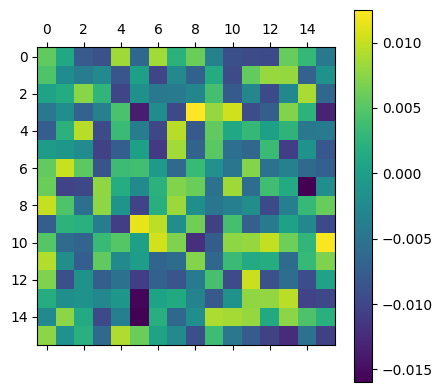

In [6]:
model1 = Net().cuda()
model1.load_state_dict(torch.load("../tests/mnist_cnn.pt"))
Linear_1 = model1.state_dict()['fc1.weight'].cpu()
L_1 = Linear_1[:16, :16]
plt.Figure(figsize=(30,30))
plt.matshow(L_1)
plt.colorbar()
plt.show()

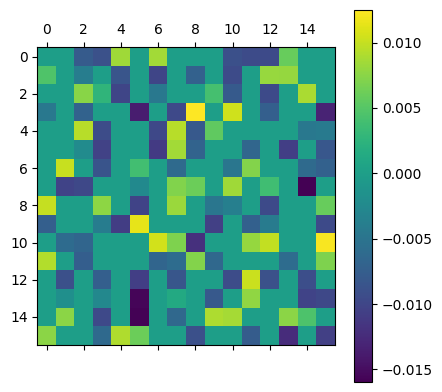

In [7]:
# mlpNet.state_dict()
Linear_1 = model.state_dict()['fc1.weight'].cpu()
L_1 = Linear_1[:16, :16]
plt.Figure(figsize=(30,30))
plt.matshow(L_1)
plt.colorbar()
plt.show()

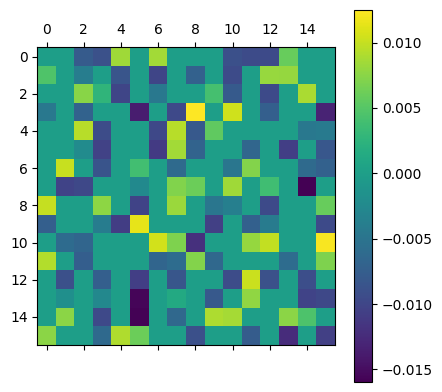

In [21]:
# mlpNet.state_dict()
Linear_1 = model.state_dict()['fc1.weight'].cpu()
L_1 = Linear_1[:16, :16]
plt.Figure(figsize=(30,30))
plt.matshow(L_1)
plt.colorbar()
plt.show()

In [8]:
test(model, "cuda", test_loader)


Test set: Average loss: 0.0593, Accuracy: 9825/10000 (98%)



# pruning in needle

In [1]:
import sys
sys.path.append('../python')

import numpy as np
import pytest
import needle as ndl
from needle import backend_ndarray as nd
import needle.nn as nn
import needle.optim as optim
from needle import data as ndldata
import needle.init as init
import needle.ops as ops
from needle.prune import model_to_sparse
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

np.random.seed(4)

/home/dudayou/miniconda3/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found permutation search CUDA kernels
[ASP][Info] permutation_search_kernels can be imported.


In [2]:
def MLPNet(dim, hidden_dim=128, num_classes=10, device=ndl.cpu_numpy()):
    ### BEGIN YOUR SOLUTION
    mlpNet = nn.Sequential(
        nn.Linear(in_features=dim, out_features=hidden_dim, device=device), 
        nn.ReLU(), 
        nn.Linear(in_features=hidden_dim, out_features=num_classes, device=device))
    return mlpNet

ndlNet = MLPNet(784, device=ndl.cuda())

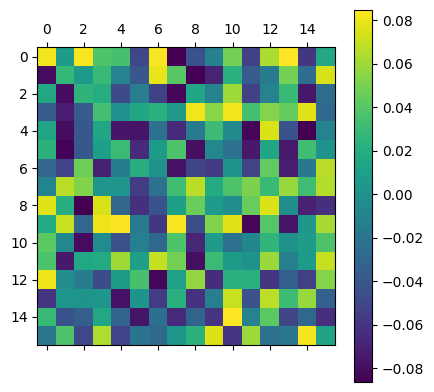

In [3]:
# mlpNet.state_dict()
Linear_1 = ndlNet.parameters()[0].numpy()
L_1 = Linear_1[:16, :16]

plt.Figure(figsize=(30,30))
plt.matshow(L_1)
plt.colorbar()
plt.show()

In [4]:
# if error need to restart
model_to_sparse(ndlNet, device=ndl.cuda())

[ASP] torchvision is imported, can work with the MaskRCNN/KeypointRCNN from torchvision.
[ASP] Sparsifying 0::weight of size=torch.Size([784, 128]) and type=torch.float32 for sparsity
[ASP] Not sparsifying 0::bias of size=torch.Size([784]) and type=torch.float32
[ASP] Auto skipping pruning 2::weight of size=torch.Size([10, 784]) and type=torch.float32 for sparsity
[ASP] Not sparsifying 2::bias of size=torch.Size([10]) and type=torch.float32
[ASP] Enabled 50.00% sparsity for 0::weight of size=torch.Size([784, 128]) and type=torch.float32


TODO: refer https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

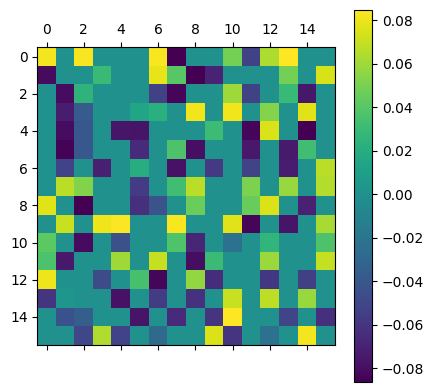

In [5]:
# mlpNet.state_dict()
Linear_1 = ndlNet.parameters()[0].numpy()
L_1 = Linear_1[:16, :16]

plt.Figure(figsize=(30,30))
plt.matshow(L_1)
plt.colorbar()
plt.show()